In [10]:
from google.colab import files
uploaded = files.upload()

Saving SMSSpamCollection.tsv to SMSSpamCollection.tsv


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


In [38]:
df = pd.read_csv('SMSSpamCollection.tsv' , header=None , sep='\t' )
df.head()

,0,1
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [13]:
df.shape

(5568, 2)

In [39]:
df.columns = ['label' , 'body_text']
df.head()

,label,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [15]:
df.describe()

,label,body_text
count,5568,5568
unique,2,5165
top,ham,"Sorry, I'll call later"
freq,4822,30


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5568 non-null   object
 1   body_text  5568 non-null   object
dtypes: object(2)
memory usage: 87.1+ KB


In [21]:
df.isnull().sum()

label        0
body_text    0
dtype: int64

In [17]:
df.groupby('label').describe()

body_text                                                               
          count unique                                                top freq
label                                                                         
ham        4822   4513                             Sorry, I'll call later   30
spam        746    652  Please call our customer service representativ...    4

We have 4822 ham message and 746 spam message.

The most frequent ham message is: "Sorry, I'll call later"

The most frequent spam message is: "Please call our customer.."

In [18]:
df.label.value_counts()

ham     4822
spam     746
Name: label, dtype: int64

Text(0, 0.5, 'Count')

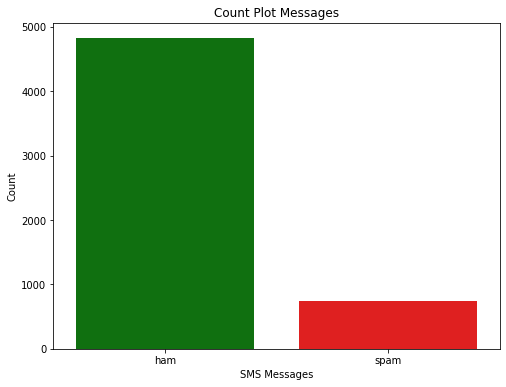

In [33]:
cols= ["green", "red"] 
plt.figure(figsize=(8,6))

fig = sns.countplot(x= df["label"], palette= cols)

fig.set_title("Count Plot Messages")
fig.set_xlabel("SMS Messages")
fig.set_ylabel("Count")

In [40]:
df['spam'] = df['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
df.head(10)

,label,body_text,spam
0,ham,I've been searching for the right words to tha...,0
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,ham,"Nah I don't think he goes to usf, he lives aro...",0
3,ham,Even my brother is not like to speak with me. ...,0
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,0
5,ham,As per your request 'Melle Melle (Oru Minnamin...,0
6,spam,WINNER!! As a valued network customer you have...,1
7,spam,Had your mobile 11 months or more? U R entitle...,1
8,ham,I'm gonna be home soon and i don't want to tal...,0
9,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [41]:
df['message_len'] = df['body_text'].apply(len)
df.head(10)

,label,body_text,spam,message_len
0,ham,I've been searching for the right words to tha...,0,196
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
2,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
3,ham,Even my brother is not like to speak with me. ...,0,77
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,0,35
5,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
6,spam,WINNER!! As a valued network customer you have...,1,157
7,spam,Had your mobile 11 months or more? U R entitle...,1,154
8,ham,I'm gonna be home soon and i don't want to tal...,0,109
9,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1,136


Text(0.5, 0, 'Message Length')

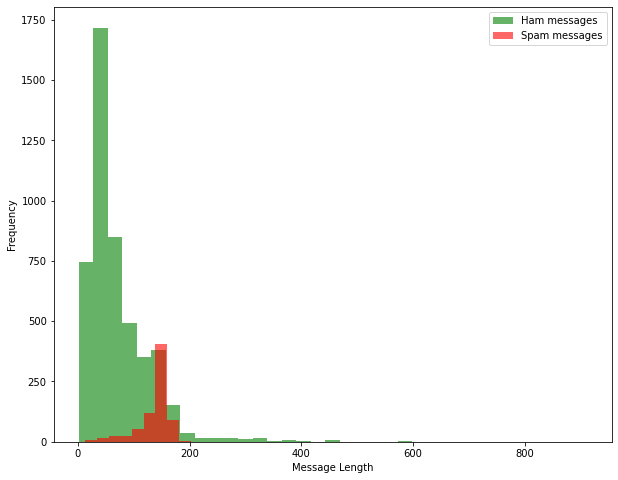

In [45]:
plt.figure(figsize=(10, 8))

df[df.label=='ham'].message_len.plot(bins=35, kind='hist', color='green', 
                                       label='Ham messages', alpha=0.6)
df[df.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [46]:
df_ham  = df[df['spam'] == 0].copy()
df_spam = df[df['spam'] == 1].copy()

In [52]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['body_text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

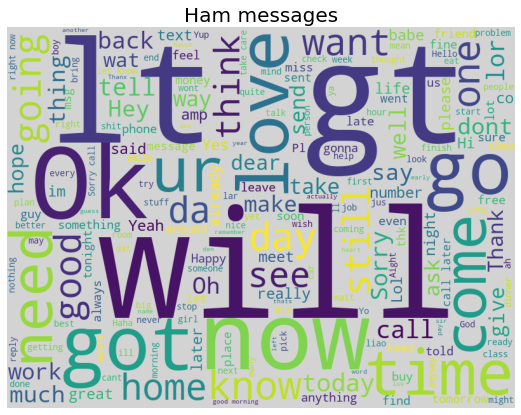

In [53]:
show_wordcloud(df_ham , "Ham messages")

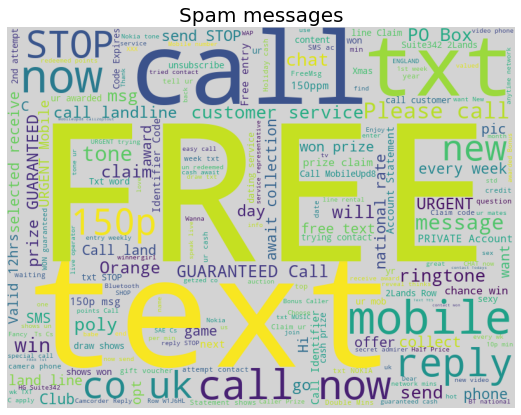

In [54]:
show_wordcloud(df_spam, "Spam messages")

In [55]:
p = string.punctuation
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [57]:
def clean_text(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Lemmatize all words
    4. Return a string lemmatized
    """
    doc = nlp (text)
    text_nopunct = [char.text.lower() for char in doc if char.text not in p ]
    text_no_stopwords = " ".join([char for char in text_nopunct if char not in stopwords])
    text_no_stopwords = nlp ( text_no_stopwords )
    text_lemmatized = " ".join([word.lemma_ for word in text_no_stopwords])
    return text_lemmatized

In [58]:
tfidf = TfidfVectorizer(preprocessor= clean_text)
vectors = tfidf.fit_transform(df['body_text']).toarray()
feature_names = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
X = pd.DataFrame(vectors, columns=feature_names)
y = df['label']
print(X.shape)
print(y.shape)

(5568, 7715)
(5568,)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
print(X_train.shape)
print(X_test.shape)

(4454, 7715)
(1114, 7715)


In [64]:
print(y_train.shape)
print(y_test.shape)

(4454,)
(1114,)


In [81]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [82]:
# accuracy on test data
X_test_prediction = nb.predict(X_test)
test_data_accuracy = round (accuracy_score(X_test_prediction, y_test)*100,2)
print('Accuracy on Test data : ', test_data_accuracy)

Accuracy on Test data :  97.13


In [83]:
print('--- Classification report for NB model ---')
print(classification_report(y_test, X_test_prediction))

--- Classification report for NB model ---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       149

    accuracy                           0.97      1114
   macro avg       0.98      0.89      0.93      1114
weighted avg       0.97      0.97      0.97      1114



In [84]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [73]:
# accuracy on test data
X_test_prediction = dt.predict(X_test)
test_data_accuracy = round (accuracy_score(X_test_prediction, y_test)*100,2)
print('Accuracy on Test data : ', test_data_accuracy)

Accuracy on Test data :  96.86


In [85]:
print('--- Classification report for DT model ---')
print(classification_report(y_test, X_test_prediction))

--- Classification report for DT model ---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       149

    accuracy                           0.97      1114
   macro avg       0.98      0.89      0.93      1114
weighted avg       0.97      0.97      0.97      1114



In [86]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [87]:
# accuracy on test data
X_test_prediction = lr.predict(X_test)
test_data_accuracy = round (accuracy_score(X_test_prediction, y_test)*100,2)
print('Accuracy on Test data : ', test_data_accuracy)

Accuracy on Test data :  95.87


In [88]:
print('--- Classification report for LR model ---')
print(classification_report(y_test, X_test_prediction))

--- Classification report for LR model ---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       0.98      0.70      0.82       149

    accuracy                           0.96      1114
   macro avg       0.97      0.85      0.90      1114
weighted avg       0.96      0.96      0.96      1114

